In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
import sys
import os

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")

In [4]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)
invalid_subjs = qa_records['invalid']

In [5]:
RESULTS_PATH = os.path.join(get_n_dir_up(CUR_PATH, 3), 'results')
PLOTS_FOLDER = os.path.join(RESULTS_PATH, 'images', 'oscillations')

## Load the prediction data

In [6]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

In [7]:
has_both_lmb = lambda df: ((df['stim_1_to_report']) & (df['stim_2_to_report'])).to_numpy()

In [8]:
TRIAL_TIMEPOINT_PRED_PATH = os.path.join(
    RESULTS_PATH, 'stats', 'gaze', 'inverted_enc', 'predictions')

### for now we only need the accuracy score for each stim at each time point

In [9]:
def deg_signed_diff(d1, epoch=180):
    d2 = - np.sign(d1) * (epoch - np.abs(d1))
    mask = np.abs(d1) < np.abs(d2)
    d = mask * d1 + (~mask) * d2
    # finally, convert 90 to -90
    half_epoch = epoch // 2
    mask_90 = d == half_epoch
    d = mask_90 * (-half_epoch) + (~mask_90) * d
    return d

def compute_accuracy(distrib, T=180):
    # 0 --> err = 0
    # 0.5 --> max err
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.cos(np.deg2rad(errs))

    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)
    acc = np.sum(distrib_vec * baseline_vec, axis=-1)
    return acc


In [10]:
def load_stim_acc_scores(mode, stim_id):
    gaze_aligned_path = os.path.join(
        TRIAL_TIMEPOINT_PRED_PATH,  f'{mode}_delay_phase')
    phase_names = [f for f in os.listdir(gaze_aligned_path) if f.startswith('phase_')]
    n_phases = len(phase_names)
    collected = []
    for phase_id in range(n_phases):
        phase_pred_path = os.path.join(
            gaze_aligned_path, f'phase_{phase_id}', 'aligned', f'stim_{stim_id}', 'target.npy')
        loaded = np.load(phase_pred_path)
        # compute accuracy
        accs = compute_accuracy(loaded)
        collected.append(accs)
    collected = np.array(collected) # (n_phases, n_trials)
    return collected

def collect_mode_gaze_accs(mode):
    collected_gaze_accs = []
    for stim_id in [1, 2]:
        gaze_accs = load_stim_acc_scores(mode, stim_id)
        collected_gaze_accs.append(gaze_accs)
    collected_gaze_accs = np.array(collected_gaze_accs) # (2, n_phases, n_trials)
    collected_gaze_accs = np.transpose(collected_gaze_accs, (2, 1, 0)) # (n_trials, n_phases, 2)

    # collect df
    df_path = os.path.join(
        TRIAL_TIMEPOINT_PRED_PATH, f'{mode}_delay_phase', 'y_df.csv')
    df = pd.read_csv(df_path, index_col=0)
    
    return collected_gaze_accs, df

In [11]:
draw_gaze_accs, draw_df = collect_mode_gaze_accs('draw')
two_items_mask = has_both_lmb(draw_df)
draw_gaze_accs = draw_gaze_accs[two_items_mask]
draw_df = draw_df[two_items_mask]

In [12]:
click_gaze_accs, click_df = collect_mode_gaze_accs('click')
two_items_mask = has_both_lmb(click_df)
click_gaze_accs = click_gaze_accs[two_items_mask]
click_df = click_df[two_items_mask]

### Keep only trials that people do remember the result, and stim1 stim 2 differ enough

In [13]:
def compute_errs(df, stim_id):
    stims = df[f'stim_{stim_id}']
    resps = df[f'resp_{stim_id}']
    errs = deg_signed_diff(resps-stims, epoch=180)
    errs = np.abs(errs)
    return errs


In [14]:
MAX_BEHAV_ERR = 30
MIN_STIM_DIFF = 20
def get_acc_filter(df, accs, err_thresh=MAX_BEHAV_ERR, diff_thresh=MIN_STIM_DIFF):
    # filter by accuracy
    mask = (compute_errs(df, 1) < err_thresh) & (compute_errs(df, 2) <= err_thresh)
    # filter by stim difference
    mask = mask & (deg_signed_diff(df['stim_1'] - df['stim_2']).abs() >= diff_thresh)
    df = df[mask]
    accs = accs[mask]
    return df, accs

In [15]:
draw_df, draw_gaze_accs = get_acc_filter(draw_df, draw_gaze_accs)

In [16]:
click_df, click_gaze_accs = get_acc_filter(click_df, click_gaze_accs)

## Compute the confidence for each target

In [17]:
import matplotlib.pyplot as plt

In [18]:
def acc_to_confidence(accs, baseline=0):
    confs = np.exp(accs)
    confs = confs / (np.sum(confs, axis=-1, keepdims=True) + np.exp(baseline))
    return confs

In [19]:
draw_gaze_confs = acc_to_confidence(draw_gaze_accs)
click_gaze_confs = acc_to_confidence(click_gaze_accs)

## Oscillation analysis

In [20]:
TIME_WINDOW = 1.05
TIME_WINDOW_STEP = 0.35
N_TIME_WINDOWS = draw_gaze_accs.shape[1]
test_times = (np.arange(N_TIME_WINDOWS) * TIME_WINDOW_STEP) + TIME_WINDOW/2

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.fftpack import fft, fftfreq
from scipy.signal import correlate

from sklearn.cluster import KMeans

def compute_states_transisiton(time, dominant_state,n_states):
    transition_counts = np.zeros((n_states, n_states)) 
    dwell_times = {k: [] for k in range(n_states)}

    # Compute transition counts and dwell times
    N_trials, T = dominant_state.shape
    dt = time[1] - time[0]
    for i in range(N_trials):
        prev_state = dominant_state[i, 0]
        dwell_time = 0
        
        for t in range(1, T):
            curr_state = dominant_state[i, t]
            if curr_state == prev_state:
                dwell_time += dt
            else:
                dwell_times[prev_state].append(dwell_time)  # Record dwell time
                transition_counts[int(prev_state),
                                  int(curr_state)] += 1
                prev_state = curr_state
                dwell_time = dt  # Reset dwell time

    # Normalize transition matrix
    transition_probs = transition_counts / np.sum(transition_counts, axis=1, keepdims=True)

    return transition_probs

def compute_fft_autocorr(time, conf1, conf2):
    T = len(time)
    dt = time[1] - time[0]
    freq = fftfreq(T, d=dt)[:T // 2]

    # Compute FFT and Autocorrelation for confidence signals
    mean_conf1 = np.mean(conf1, axis=0)
    mean_conf2 = np.mean(conf2, axis=0)
    mean_conf_delta = mean_conf1 - mean_conf2

    fft_delta = np.abs(fft(mean_conf_delta))[:T // 2]
    auto_corr_delta = correlate(mean_conf_delta - np.mean(mean_conf_delta), mean_conf_delta - np.mean(mean_conf_delta), mode='full')
    auto_corr_delta = auto_corr_delta[T - 1:]  # Keep only positive lags
    lags = np.arange(T) * dt

    return freq, fft_delta, lags, auto_corr_delta

def sort_trials_by_clusters(raster_data, num_clusters=8):
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(raster_data)
    ## compute non-zero frequency per cluster
    cluster_frequencies = np.zeros(num_clusters)
    for i in range(num_clusters):
        cluster_frequencies[i] = np.mean(raster_data[cluster_labels == i] > 0)
    sorted_cluster_indices = np.argsort(cluster_frequencies)  # Sort indices
    cluster_mapping = {old: new for new, old in enumerate(sorted_cluster_indices)}
    new_cluster_labels = np.array([cluster_mapping[label] for label in cluster_labels])
    ## reorder trials based on new cluster labels
    sorted_indices = np.argsort(new_cluster_labels)  # Sort trials by new cluster order
    return sorted_indices

def plot_state_plot(ax, states, n_states, state_colors):
    cmap = mcolors.ListedColormap(state_colors)
    bounds = np.arange(n_states+1) - 0.5
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    raster_data = states

    # sort the trials by 'patterns'
    state_plot = ax.imshow(
        raster_data, aspect='auto', cmap=cmap, norm=norm, interpolation='nearest')
    ax.set_xlabel("Time")
    ax.set_ylabel("Trial")

    return state_plot

def plot_fft_autocorr(ax, freq, fft_delta, color):
    ax.plot(freq, fft_delta, color=color)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude")

def plot_latency_autocorr(ax, lags, auto_corr_delta, color):
    ax.plot(lags, auto_corr_delta, color=color)
    ax.set_xlabel("Time Lag")    
    ax.set_ylabel("Autocorrelation")

def autocorr_to_switch_points(autocorrs):
    # find all zero crossing points
    assert len(autocorrs.shape) == 1
    left_sign = np.sign(autocorrs[:-1])
    right_sign = np.sign(autocorrs[1:])
    zero_crossing = np.where((left_sign * right_sign) < 0)
    return zero_crossing[0]

CONF_THRESH = 0.5 # confidence threshold
TITLE_SIZE = 16
def summarize_oscillations_across_trials(time, conf_target1_trials, conf_target2_trials, plot_name):
    # Compute dominant state per trial
    N_trials, T = conf_target1_trials.shape
    dominant_state = np.zeros((N_trials, T)).astype(int)  # Initialize with NaNs
    conf_thresh = CONF_THRESH
    mask_t1 = (conf_target1_trials > conf_thresh) & (conf_target1_trials > conf_target2_trials)
    mask_t2 = (conf_target2_trials > conf_thresh) & (conf_target2_trials > conf_target1_trials)
    dominant_state[mask_t1] = 1
    dominant_state[mask_t2] = 2

    # three state masks
    # - Nan, state 1, state 2
    # - Non-state 1, state 1
    # - Non-state 2, state 2
    statemap_titles = [
        'All states',
        'Target 1 v.s. Non Target 1',
        'Target 2 v.s. Non Target 2',
    ]
    all_state_names = [
        ['nan', 'target 1', 'target 2'],
        ['other', 'target 1'],
        ['other', 'target 2'],
    ]
    states_result = [
        dominant_state,
        (dominant_state == 1).astype(int),
        (dominant_state == 2).astype(int)
    ]
    state_conf_results = [
        (conf_target1_trials, conf_target2_trials),
        (conf_target1_trials, 1 - conf_target1_trials),
        (conf_target2_trials, 1 - conf_target2_trials),
    ]
    all_state_colors = [
        ['white', 'purple', 'green'],
        ['white', 'purple'],
        ['white', 'green'],
    ]
    plot_colors =[
        'dimgray', 'purple', 'green'
    ]

    results = {} # to store some of results

    fig, axs = plt.subplots(3, 4, figsize=(16, 9))
    trial_sorted_indices = None
    for i in range(3):
        # number of states
        state_colors = all_state_colors[i]
        n_states = len(state_colors)

        statemap_title = statemap_titles[i]
        statemap = states_result[i]
        conf1, conf2 = state_conf_results[i]

        # compute stats
        freq, fft_delta, lags, auto_corr_delta = compute_fft_autocorr(
            time, conf1, conf2)

        # plot the state map
        trial_sorted_indices = sort_trials_by_clusters(statemap)
        statemap = statemap[trial_sorted_indices]
        state_plot = plot_state_plot(axs[i, 0], statemap, n_states, state_colors)
        state_names = all_state_names[i]
        cbar = fig.colorbar(
            state_plot, ax=axs[i, 0], 
            ticks=np.arange(n_states).astype(int), 
            fraction=0.046, pad=0.04)
        cbar.set_ticklabels(state_names)
        
        # plot the fft
        ax = axs[i, 1]
        plot_fft_autocorr(ax, freq, fft_delta, color=plot_colors[i])
        if i == 0:
            ax.set_ylim([0, 0.5])
        else:
            ax.set_ylim([0, 3])

        # plot the autocorrelation
        ax = axs[i, 2]
        plot_latency_autocorr(ax, lags, auto_corr_delta, color=plot_colors[i])
        ax.set_ylim([-0.004, 0.01])
        ax.axhline(0, color='y', linestyle='--')

        # store the shift points
        if i == 0:
            autocorr_shift_points = autocorr_to_switch_points(auto_corr_delta)
            results['autocorr_shift_points'] = autocorr_shift_points
            results['autocorr_lags'] = lags

        # plot fequency
        state_feqs = np.mean(statemap>0, axis=0)
        ax = axs[i, 3]
        ax.plot(state_feqs, color=plot_colors[i])
        if i == 0:
            ax.set_ylim([0.7, 0.85])
        else:
            ax.set_ylim([0.3, 0.46])

        # set title
        axs[i, 0].set_ylabel(
            statemap_title, fontsize=12, fontweight='bold', rotation=90
            # , labelpad=100
        )

    # set titles
    axs[0, 0].set_title('states', fontsize=TITLE_SIZE)
    axs[0, 1].set_title('FFT magnitude', fontsize=TITLE_SIZE)
    axs[0, 2].set_title('autocorrelation', fontsize=TITLE_SIZE)
    axs[0, 3].set_title('avg frequency', fontsize=TITLE_SIZE)

    plt.tight_layout()

    # finally save the result
    plot_path = os.path.join(
        PLOTS_FOLDER, f'{plot_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

    return results


### Split draw and click

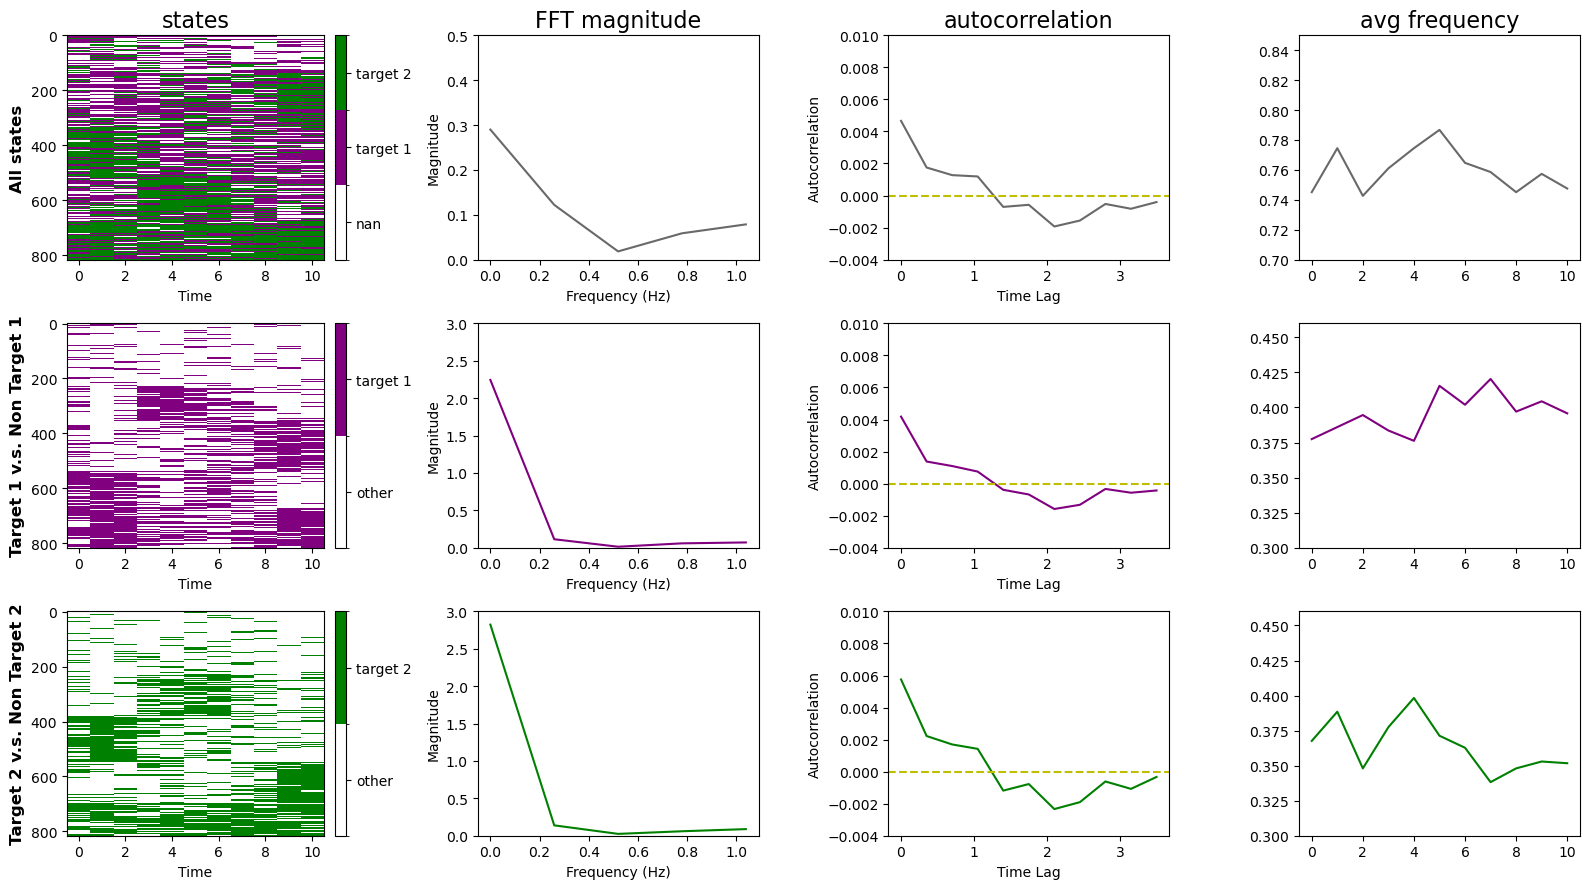

In [34]:
draw_fft_stats = summarize_oscillations_across_trials(
    test_times, draw_gaze_confs[..., 0], draw_gaze_confs[..., 1], 'draw')

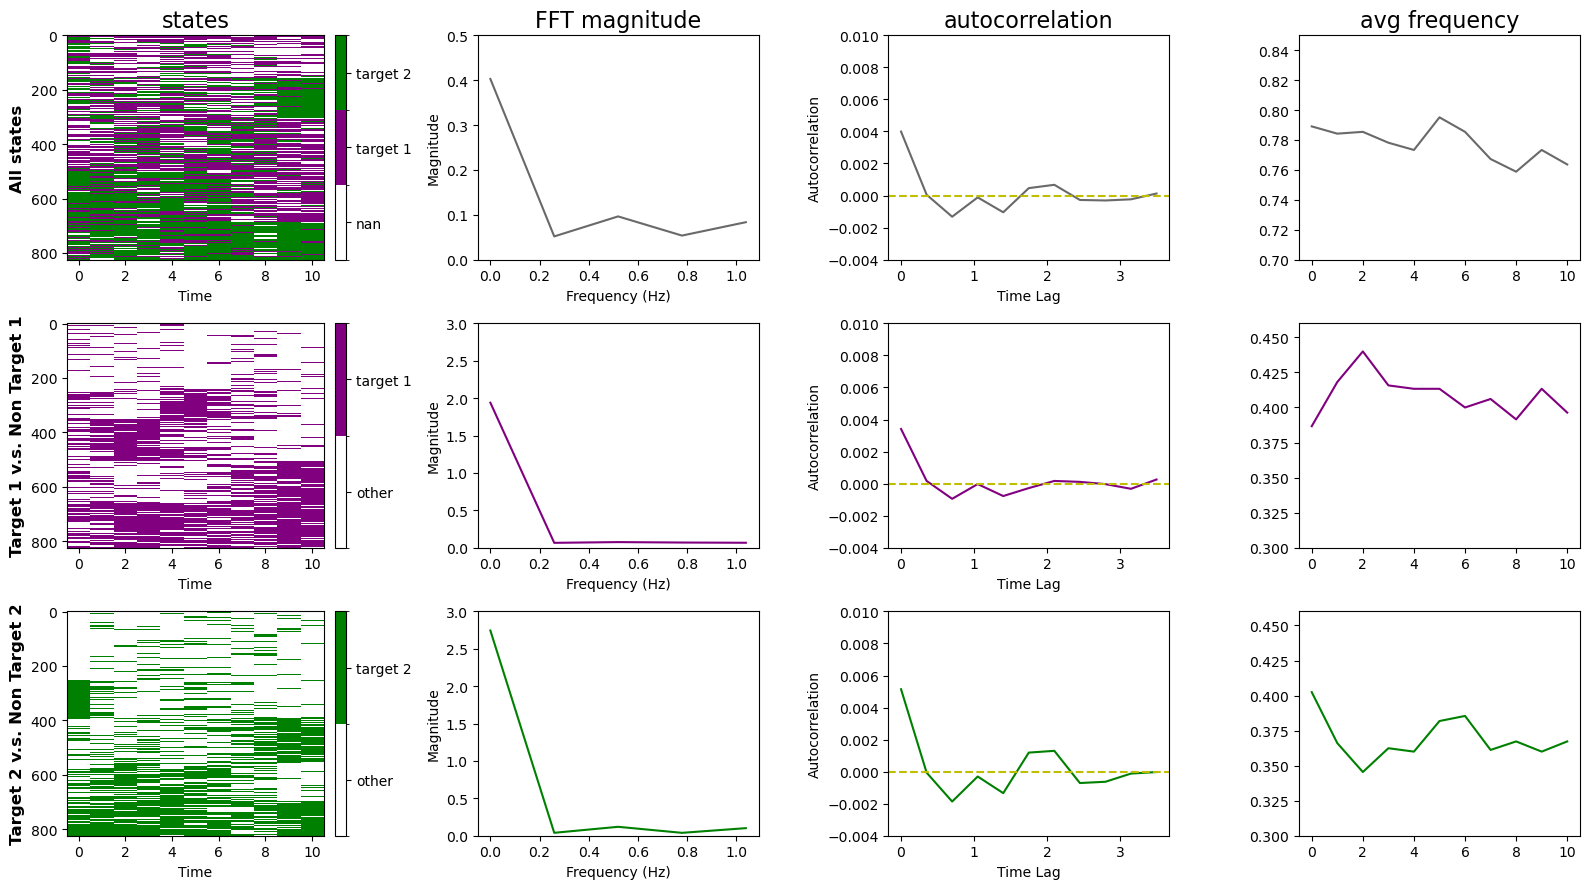

In [36]:
click_fft_stats = summarize_oscillations_across_trials(
    test_times, click_gaze_confs[..., 0], click_gaze_confs[..., 1], 'click')

In [37]:
click_fft_stats

{'autocorr_shift_points': array([1, 4, 6, 9]),
 'autocorr_lags': array([0.  , 0.35, 0.7 , 1.05, 1.4 , 1.75, 2.1 , 2.45, 2.8 , 3.15, 3.5 ])}

### Plot Decoded Dynamics

In [60]:
def plot_inferred_dynamic_diagram(fft_stats):
    gap = TIME_WINDOW_STEP * 0.3 # FOR BETTER VISUAL
    shift_points = fft_stats['autocorr_shift_points']
    lags = fft_stats['autocorr_lags']
    fig, ax = plt.subplots(figsize=(6, 2))
    # tag timepoint
    xss = [[], []]
    yss = [[], []]
    # start
    state = 2
    xss[0].append(0)
    yss[0].append(0)
    xss[1].append(0)
    yss[1].append(1)
    # shifts
    for k in shift_points:
        t = (lags[k] + lags[k+1])/2
        for state_id in [0, 1]:
            # before
            cur_y = int(state_id == (state-1))
            xss[state_id].append(t - gap)
            yss[state_id].append(cur_y)
            # after
            next_y = 1 - cur_y
            xss[state_id].append(t + gap)
            yss[state_id].append(next_y)
        state = 3 - state
    # end
    for state_id in [0, 1]:
        xss[state_id].append(lags[-1])
        yss[state_id].append(int(state_id==(state-1)))
    # plot
    state_colors = ['purple', 'green']
    for state_id in [0, 1]:
        ax.plot(xss[state_id], yss[state_id], color=state_colors[state_id], label=f'stim {state_id+1}')

    # Formatting
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axhline(0.5, color='y', linestyle='--')

    # legend
    ax.legend(
        loc='center left', fontsize=12, 
        bbox_to_anchor=(1.0, 0.5)
    )
        

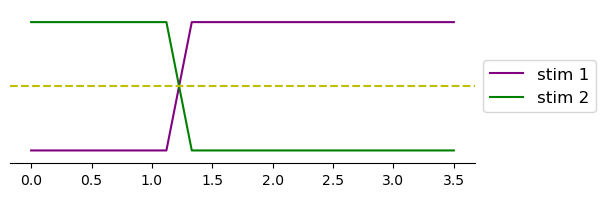

In [61]:
plot_inferred_dynamic_diagram(draw_fft_stats)
plot_path = os.path.join(
    PLOTS_FOLDER, f'draw_dynamic_diagram.png')
plt.savefig(plot_path, bbox_inches='tight')

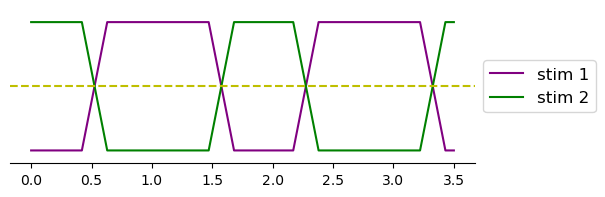

In [62]:
plot_inferred_dynamic_diagram(click_fft_stats)
plot_path = os.path.join(
    PLOTS_FOLDER, f'click_dynamic_diagram.png')
plt.savefig(plot_path, bbox_inches='tight')